# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 07/15/2022
* Student Name: Karefa Kargbo
* Student Net ID: kjk6ee
* This URL: https://github.com/Sonimon123/MonteCarlo/blob/main/FinalProject.ipynb
* GitHub Repo URL: https://github.com/Sonimon123/MonteCarlo

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd
import random
import itertools

"""Allows you to create and analyze Monte Carlo simulations"""

class Die():

    '''Creates a theoretical Die of any number of faces that can be set with various weights on each side and rolled.'''

    __faces = pd.DataFrame()

    def __init__(self, fArray):
        """Initializes dice using the Numpy ndarray of face names (with either a numeric or string dtype) provided, with all of the weights defaulting to 1"""
        assert type(fArray) == np.ndarray, "Input isn't ndarray"
        assert np.issubdtype(fArray.dtype, np.number) or np.issubdtype(fArray.dtype, np.string_) or np.issubdtype(fArray.dtype, np.unicode_), "Input does not have correct datatype"

        self.__faces = pd.DataFrame({'Face': fArray,
                                      'Weight': np.ones(fArray.size)})
    
    def setWeight(self, face, weight):
        """Sets the weight of the die face provided to the weight provided"""
        assert face in self.__faces.Face.values, "Face provided is not in list of faces"
        try:
            float(weight)
        except ValueError:
            print("Weights must be convertable to Floating Point Numbers.")
            return
        
        #Searches for the face in the list of weights with the name of the face given, then sets the weight to the given value
        self.__faces.loc[self.__faces['Face'] == face, 'Weight'] = weight

    def roll(self, count = 1):
        """'Rolls' the die you created, giving you a random face, with the chance of each face being determined by the weights in the dataframe"""
        assert type(count) == int

        out = []

        while count > 0:
            out.append(random.choices(self.__faces['Face'], self.__faces["Weight"]))
            count -= 1

        return out

    def seeDie(self):
        """Prints the faces and weights of the die"""
        return self.__faces

class Game():

    '''Allows you to save several Dice, roll them any given number of times, then see the outcome of those rolls'''

    dice = []
    __playframe = pd.DataFrame()

    def __init__(self, dList):
        #All inputs must be dice, and all die must have similar faces
        for x in dList:
            assert type(x) == Die or '__main__.Die', "All items in dList must be a Die"
            assert pd.Series.equals(x.seeDie()['Face'], dList[1].seeDie()['Face']), "All dice must have similar faces and number of faces"

        #Save list of dice
        self.dice = dList

    def play(self, runs):

        '''Rolls all of the dice in the game the specified amount of times, then saves the results to a private variable'''

        assert type(runs) == int, "Parameter must be an integer"

        #Create an Empty DataFrame with the correct Index and Column Names
        #Die Name is based on placement in list
        res = pd.DataFrame(columns=['Die ' + str(x) for x in range(1, len(self.dice)+1)], index=['Roll ' + str(x) for x in range(1, runs+1)])

        num = 1
        for x in self.dice:
            #For each die, roll it 'runs' times, then add the column to the dataframe
            runList = x.roll(runs)

            res["Die " + str(num)] = runList
            res["Die " + str(num)] = [x[0] for x in res["Die " + str(num)]]
            num += 1
        
        self.__playframe = res

    def show(self, narrow=False):

        '''Returns the results of the last game. Can either be given in a standard wide form or a stacked narrow form'''

        if narrow:
            return self.__playframe.stack()
        else:
            return self.__playframe


class Analyzer():

    '''Analyzes a Game object (that's already been played) and provides various pieces of information about it.'''

    game = Game([])
    comboDF = pd.DataFrame()
    jackpotDF = pd.Series()
    fcprDF = pd.DataFrame()
    __faceType = ''

    def __init__(self, game):
        '''Stores the game inside of itself, then stores the Numpy dtype of the Die Faces'''
        self.game = game
        self.__faceType = game.dice[0].seeDie()['Face'].dtype

    def jackpot(self):
        """Calculates how many times a roll ended in a Jackpot (all the same face), then stores this in the jackpotDF dataframe. Returns the number of successes"""
        res = pd.DataFrame(columns=['Jackpot?'], index=['Roll ' + str(x) for x in range(1, len(self.game.show().index) + 1)])
        jNum = 0
        
        for x in range(1, len(self.game.show().index) + 1):
            res.loc["Roll " + str(x), 'Jackpot?'] = (self.game.show().loc["Roll " + str(x)].astype(str).nunique() == 1)
            if res.loc["Roll " + str(x), 'Jackpot?']:
                jNum += 1
        self.jackpotDF = res
        return jNum

    def combo(self):
        """Calculates how many times each die outcome occured and stores the information in a dataframe. Returns the dataframe."""
        self.comboDF = self.game.show().value_counts()
        return self.comboDF

    def faceCounts(self):
        """Calculates how many times each face occured in each roll and stores it in a dataframe. Returns the dataframe."""
        fcprDF = self.game.show().T.apply(pd.value_counts).T
        return fcprDF

    def faceType(self):
        """Returns the Numpy dType of the die faces."""
        return self.__faceType


<ipython-input-1-95e509d4123e>:103: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  jackpotDF = pd.Series()


# Test Module

In [2]:
import numpy as np
import pandas as pd
import unittest
import MonteCarlo

class MonteCarloTestSuite(unittest.TestCase):

    faces1 = np.array([1,2,3,4,5,6])
    faces2 = np.array(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])
    faces3 = np.array(['heads', 'tails'])

    die1 = MonteCarlo.Die(faces1)

    def test_01_die_init_1(self):
        '''Ensure that all weights are equal after initialization'''
        
        self.assertTrue(self.die1.seeDie()['Weight'].unique().size == 1, "Dice are being initialized with imperfect weights")
    
    def test_02_die_init_2(self):
        '''Ensure that all weights are 1'''
        self.assertTrue(self.die1.seeDie()['Weight'].unique()[0] == 1, "Dice are being initialized with weights other than 1")

    def test_03_die_roll(self):
        '''Ensure that 'roll' rolls the die the correct number of times'''
        self.assertTrue(len(self.die1.roll(10)) == 10 , "Die.Roll doesn't return the right number of results")

    def test_04_die_seeDie(self):
        '''Ensure that seeDie is the correct dimensions'''
        self.assertTrue(self.die1.seeDie().shape == (self.faces1.size, 2), "Die.seeDie returns the wrong number of faces.")

    die2 = MonteCarlo.Die(faces2)
    die3 = MonteCarlo.Die(faces3)

    def test_05_game_init(self):
        '''Ensure that a Game Object will not be created with non-matching dice'''
        with self.assertRaises(AssertionError):
            game0 = MonteCarlo.Game([self.die1, self.die2, self.die3])
    
    game1 = MonteCarlo.Game([die1, die1, die1, die1, die1])

    def test_06_game_play(self):
        '''Ensure that the dataframe created when a game is played has the correct shape given a known number of dice and rolls'''
        self.game1.play(10)
        self.assertTrue(self.game1.show().shape == (10, 5), "Shape of game results dataframe incorrect. Implies missing/incorrect data")

    def test_07_game_play(self):
        '''Check that shape of stacked dataframe is correct'''
        self.assertTrue(self.game1.show(True).shape == (50,), "Stacked data gives incorrect shape")

    game2 = MonteCarlo.Game([die3, die3, die3, die3])
    game2.play(10)
    analyzer1 = MonteCarlo.Analyzer(game2)

    def test_08_analyzer_init(self):
        '''Check that dtype of correct subtype is given when creating analyzer (Strings become object dtype)'''
        self.assertTrue(np.issubdtype(self.analyzer1.faceType(), np.object_), "Analyzer somehow saving incorrect dType information")

    def test_09_analyzer_jackpot(self):
        '''Check that the jackpot returns possible result'''
        self.assertTrue(0 <= self.analyzer1.jackpot() <= 10 , "Jackpot giving impossible result")

    def test_10_analyzer_combo(self):
        '''Check that sum of combo values adds up to number of rolls'''
        self.assertTrue(sum(self.analyzer1.combo()) == 10, "Combo is returning the wrong amount of values")

    def test_11_analyzer_faceCounts(self):
        '''Check that number of faceCounts columns equals number of known die faces'''
        self.assertTrue(self.analyzer1.faceCounts().columns.size == 2, "faceCounts has an incorrect number of die faces")

    def test_12_analyzer_faceType(self):
        '''Check that faceType is returning correct FaceType'''
        self.assertTrue(np.issubdtype(self.analyzer1.faceType(), np.object_), "Analyzer storing faceType incorrectly")

if __name__ == '__main__':
    
    unittest.main(verbosity=3)

/sfs/qumulo/qhome/kjk6ee/ (unittest.loader._FailedTest) ... ERROR

ERROR: /sfs/qumulo/qhome/kjk6ee/ (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/sfs/qumulo/qhome/kjk6ee/'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


SystemExit: True

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

In [3]:
import numpy as np
import pandas as pd
import MonteCarlo

Scenario 1: 2-Headed Coin

1.1

In [4]:
cArray = np.array(['H', 'T'])

fCoin = MonteCarlo.Die(cArray)
uCoin = MonteCarlo.Die(cArray)

uCoin.setWeight('T', 5)

fCoin.seeDie()

,Face,Weight
0,H,1.0
1,T,1.0


In [5]:
uCoin.seeDie()

,Face,Weight
0,H,1.0
1,T,5.0


1.2 - 1.3

In [6]:
game1 = MonteCarlo.Game([fCoin, fCoin, fCoin])
game1.play(1000)
game2 = MonteCarlo.Game([uCoin, uCoin, fCoin])
game2.play(1000)

1.4

In [7]:
analyzer1 = MonteCarlo.Analyzer(game1)
analyzer1.jackpot()
analyzer1.jackpotDF.value_counts(normalize=True)

Jackpot?
False       0.754
True        0.246
dtype: float64

In [8]:
analyzer2 = MonteCarlo.Analyzer(game2)
analyzer2.jackpot()
analyzer2.jackpotDF.value_counts(normalize=True)

Jackpot?
False       0.644
True        0.356
dtype: float64

1.5

In [9]:
rf1 = analyzer1.jackpot() / 1000
rf2 = analyzer2.jackpot() / 1000

1.6

<AxesSubplot:>

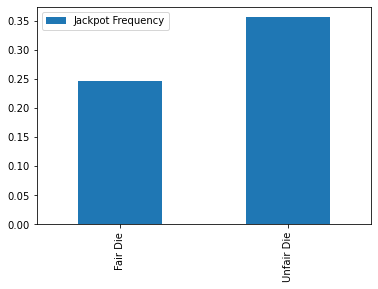

In [10]:
data = {'Jackpot Frequency': [rf1, rf2]}
rfDF = pd.DataFrame(data, index=['Fair Die', 'Unfair Die'])
rfDF.plot.bar()

## Scenario 2

In [11]:
# Code blocks with output

In [12]:
import numpy as np
import pandas as pd
import MonteCarlo

Scenario 2: 6-Sided die

2.1

In [13]:
dArray = np.array([1,2,3,4,5,6])

fd1 = MonteCarlo.Die(dArray)
ud1 = MonteCarlo.Die(dArray)
ud1.setWeight(6, 5)
ud2 = MonteCarlo.Die(dArray)
ud2.setWeight(1, 5)

In [14]:
fd1.seeDie()

,Face,Weight
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0


In [15]:
ud1.seeDie()

,Face,Weight
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,5.0


In [16]:
ud2.seeDie()

,Face,Weight
0,1,5.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0


2.2

In [17]:
game1 = MonteCarlo.Game([fd1, fd1, fd1, fd1, fd1])
game1.play(10000)

2.3

In [18]:
game2 = MonteCarlo.Game([ud1, ud1, ud2, fd1, fd1])
game2.play(10000)

2.4

In [19]:
analyzer1 = MonteCarlo.Analyzer(game1)
analyzer1.jackpot()
analyzer1.jackpotDF.value_counts(normalize=True)

Jackpot?
False       0.9995
True        0.0005
dtype: float64

In [20]:
analyzer2 = MonteCarlo.Analyzer(game2)
analyzer2.jackpot()
analyzer2.jackpotDF.value_counts(normalize=True)

Jackpot?
False       0.9992
True        0.0008
dtype: float64

<AxesSubplot:>

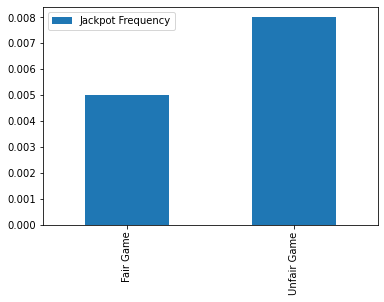

In [21]:
rf1 = analyzer1.jackpot() / 1000
rf2 = analyzer2.jackpot() / 1000

data = {'Jackpot Frequency': [rf1, rf2]}
rfDF = pd.DataFrame(data, index=['Fair Game', 'Unfair Game'])
rfDF.plot.bar()

2.5

<AxesSubplot:xlabel='Die 1,Die 2,Die 3,Die 4,Die 5'>

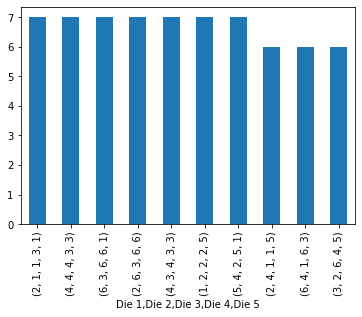

In [22]:
analyzer1.combo()[:10].plot.bar()

<AxesSubplot:xlabel='Die 1,Die 2,Die 3,Die 4,Die 5'>

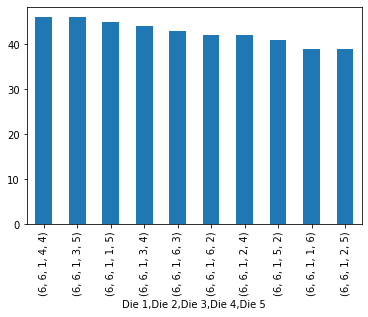

In [23]:
analyzer2.combo()[:10].plot.bar()

## Scenario 3

In [24]:
# Code blocks with output

Scenario 3: Roman Alphabet

3.1

In [25]:
lArray = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
weightArray = np.array([8.4966,2.0720,4.5388,3.3844,11.1607,1.8121,2.4705,3.0034,7.5448,0.1965,1.1016,5.4893,3.0129,6.6544,7.1635,3.1671,0.1962,7.5809,5.7351,6.9509,3.6308,1.0074,1.2899,0.2902,1.7779,0.2722])

lettDie = MonteCarlo.Die(lArray)

for i in range(26):
    lettDie.setWeight(lArray[i], weightArray[i])

lettDie.seeDie()

,Face,Weight
0,A,8.4966
1,B,2.0720
2,C,4.5388
3,D,3.3844
4,E,11.1607
5,F,1.8121
6,G,2.4705
7,H,3.0034
8,I,7.5448
9,J,0.1965


3.2

In [26]:
game1 = MonteCarlo.Game([lettDie,lettDie,lettDie,lettDie,lettDie])
game1.play(1000)

3.3

In [27]:
analyzer1 = MonteCarlo.Analyzer(game1)
pd.options.display.max_rows = 2000
game1.show()

,Die 1,Die 2,Die 3,Die 4,Die 5
Roll 1,S,D,A,S,G
Roll 2,E,B,A,U,O
Roll 3,I,A,S,E,F
Roll 4,E,R,I,E,Y
Roll 5,R,F,N,A,O
Roll 6,N,O,E,A,L
Roll 7,L,B,A,R,O
Roll 8,D,I,U,N,P
Roll 9,N,F,N,E,E
Roll 10,T,F,I,T,C


I couldn't find any combinations of 5 letters that made words, but I did see a few 4 letter words with an extra letter.

3.4

In [28]:
game1.play(1000)
game1.show()

,Die 1,Die 2,Die 3,Die 4,Die 5
Roll 1,T,O,K,I,M
Roll 2,R,O,T,O,T
Roll 3,R,R,H,P,E
Roll 4,L,I,O,R,S
Roll 5,U,K,A,N,R
Roll 6,T,P,D,O,A
Roll 7,C,G,C,K,O
Roll 8,O,E,O,L,B
Roll 9,C,E,E,O,P
Roll 10,D,W,T,I,I


Running the game 2 different times and looking over the results, the results I found for giving actual words was 1/2000.

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [29]:
!ls -lRF -o

.:
total 676
-rw-r--r-- 1 kjk6ee  31442 Jul 17 17:11 FinalProject.ipynb
-rw-r--r-- 1 kjk6ee   1067 Jul 17 16:50 LICENSE
drwxr-sr-x 4 kjk6ee   2048 Jul 17 17:04 MonteCarlo/
drwxr-sr-x 2 kjk6ee   2560 Jul 17 17:08 MonteCarlo.egg-info/
-rw-r--r-- 1 kjk6ee 614690 Jul 17 16:50 montecarlo_scenarios.ipynb
-rw-r--r-- 1 kjk6ee      0 Jul 17 17:11 montecarlo_testresults.txt
-rw-r--r-- 1 kjk6ee   5796 Jul 17 16:50 README.md
-rw-r--r-- 1 kjk6ee    407 Jul 17 16:50 setup.py

./MonteCarlo:
total 24
-rw-r--r-- 1 kjk6ee   89 Jul 17 16:50 __init__.py
-rw-r--r-- 1 kjk6ee 5330 Jul 17 16:50 MonteCarlo.py
drwxr-sr-x 2 kjk6ee 1024 Jul 17 17:04 __pycache__/
drwxr-sr-x 3 kjk6ee 1536 Jul 17 17:11 test/

./MonteCarlo/__pycache__:
total 16
-rw-r--r-- 1 kjk6ee  267 Jul 17 17:04 __init__.cpython-38.pyc
-rw-r--r-- 1 kjk6ee 6036 Jul 17 17:04 MonteCarlo.cpython-38.pyc

./MonteCarlo/test:
total 16
-rw-r--r-- 1 kjk6ee 3507 Jul 17 17:02 montecarlo_test.py
-rw-r--r-- 1 kjk6ee 1559 Jul 17 17:11 montecarlo_testresults.txt


# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [30]:
!pip install -e '/sfs/qumulo/qhome/kjk6ee/Documents/MSDS/DS5100/MonteCarlo'

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/kjk6ee/Documents/MSDS/DS5100/MonteCarlo
  Attempting uninstall: MonteCarlo
    Found existing installation: MonteCarlo 1.0
    Uninstalling MonteCarlo-1.0:
      Successfully uninstalled MonteCarlo-1.0
  Running setup.py develop for MonteCarlo
